<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Scrape-URLs" data-toc-modified-id="Scrape-URLs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scrape URLs</a></span><ul class="toc-item"><li><span><a href="#Base-Page" data-toc-modified-id="Base-Page-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Base Page</a></span></li><li><span><a href="#Collect-all-URLs-for-each-report" data-toc-modified-id="Collect-all-URLs-for-each-report-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Collect all URLs for each report</a></span></li><li><span><a href="#Sanity-Check" data-toc-modified-id="Sanity-Check-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Sanity Check</a></span></li><li><span><a href="#Save-for-later-use" data-toc-modified-id="Save-for-later-use-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Save for later use</a></span></li></ul></li><li><span><a href="#Download-and-extract-files" data-toc-modified-id="Download-and-extract-files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Download and extract files</a></span></li><li><span><a href="#File-Types" data-toc-modified-id="File-Types-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>File Types</a></span><ul class="toc-item"><li><span><a href="#zip-files" data-toc-modified-id="zip-files-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>zip files</a></span></li><li><span><a href="#Alternate-versions" data-toc-modified-id="Alternate-versions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Alternate versions</a></span></li><li><span><a href="#txt-files" data-toc-modified-id="txt-files-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>txt files</a></span></li><li><span><a href="#sas-files" data-toc-modified-id="sas-files-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>sas files</a></span></li></ul></li></ul></div>

In [1]:
from bs4 import BeautifulSoup
import requests
import requests_cache

import pandas as pd
import numpy as np
import os
import shutil

from urllib.parse import urljoin
from tqdm import tqdm

import time
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

In [2]:
# start requests cache so we can rurun the notebook without querying cms.gov
requests_cache.install_cache('cms_cache')

# Scrape URLs
## Base Page

In [3]:
START_URL = 'https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/MCRAdvPartDEnrolData'

In [4]:
def get_page_soup(url, params = {'items_per_page':100}): 
    'request a page'
    r = requests.get(url,params=params)    
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

In [5]:
# get the start url and convert to soup
soup = get_page_soup(START_URL, params = {})

In [6]:
# parse links to report types from left menu
left_menu = soup.find("div", {"id": 'block-cmsmainnavigation'})
reports = left_menu.findAll("li", {"class": 'menu-item'})
report_urls = [r.find("a")['href'] for r in reports]
report_urls[:5]

['/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/MCRAdvPartDEnrolData/Monthly-Contract-and-Enrollment-Summary-Report',
 '/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/MCRAdvPartDEnrolData/Monthly-Enrollment-by-Contract',
 '/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/MCRAdvPartDEnrolData/Monthly-Enrollment-by-Contract-Plan-State-County',
 '/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/MCRAdvPartDEnrolData/Monthly-Enrollment-by-Plan',
 '/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/MCRAdvPartDEnrolData/Monthly-Enrollment-by-State']

In [7]:
# verify that there are 26 report urls
len(report_urls)

26

## Collect all URLs for each report

In [8]:
# Util Functions

def extract_num_entries(soup):
    entries_text = soup.find('span', {'class': 'ds-l-sm-col--12'}).text.strip()
    num_entries = entries_text.split(' ')[-2]    
    return int(num_entries)

def extract_report_urls(soup):
    '''Get list of links to download pages from a list page'''
    
    # extract table rows
    table = soup.find('div', {'class':'view-content'})
    body = soup.find('tbody')
    rows = body.findAll('tr')
    
    # local data storage object
    reports = []
    
    # extract row wise data
    for row in rows:
        cells = row.findAll('td')
        
        report = {'report_period':cells[1].text,
                  'report_title':cells[0].text,
                  'report_url':cells[0].a['href']}
        reports.append(report)
    
    return reports

def extract_downloads(soup):
    '''Get download links from a downloads page'''
    
    # extract table rows
    rows = soup.findAll('div', {'class':'media--view-mode-file-list'})
    
    # local data storage object
    reports = {'report_period':[],
               'report_title':[],
               'download_url':[]}
    
    # extract row wise data
    for row in rows:

        reports['report_period'] = np.nan
        reports['report_title'].append(row.text.strip())
        reports['download_url'].append(row.a['href'])
    
    # return as DataFrame
    df = pd.DataFrame(reports)
    
    return df

def extract_page_title(soup):
    return soup.find(id='skipNavTarget').text.strip()

def extract_description(soup):
    return soup.find('div', {'id':'block-cms-drupal-global-content'}).div.p.text

def is_download_page(soup):
    if soup.find('h2', {'class':'field__label'}):
        return True
    return False

def is_links_list_page(soup):
    
    if soup.find('span', {'class': 'ds-l-sm-col--12'}):
        return True
    
    return False

def get_all_pages(url, recursion=0, verbose=True):
    '''Recursivly dig into links to find all nested download links'''
    
    # NOTE: page can be select with a combination of`page` and 
    # `items_per_page` params
    
    if verbose:
        print('Accessing', url)
        print('--> recursion:', recursion)

    params = {'items_per_page':100}
    soup = get_page_soup(url, params)
    
    if not is_links_list_page(soup):
        # for download pages, return the download links
        
        if verbose:
            print('--> extracting downloads')
        
        df = extract_downloads(soup)
        df['download_page_url'] = url
        return df
    else:
        # for link pages get all links and dig into each one
    
        if verbose:
            print('--> getting links to download pages')
        
        # get number of entries
        num_entries = extract_num_entries(soup)

        # get first page
        reports = extract_report_urls(soup)    

        # recurse to get all links
        # 0 indexed page id
        page = 0
        while len(reports) < num_entries:
            page += 1
            params['page'] = page
            soup = get_page_soup(url, params)
            reports += extract_report_urls(soup)
        
        # recurse until we have downloads
        dfs = []
        for report in reports:
            next_url = urljoin(START_URL, report['report_url'])
            dfs.append(get_all_pages(next_url, recursion+1, verbose))
            
        # combine all downloads into a single df
        df = pd.concat(dfs)
        
        # add page identifiers
        df['description'] = extract_description(soup)
        df['page_title'] = extract_page_title(soup)
        df['page_url'] = url
        
        return df

In [9]:
# get separate dataframes of all the report urls.
dfs = []

for report_url in tqdm(report_urls):
    url=urljoin(START_URL,report_url)
    dfs.append(get_all_pages(url, verbose=False))
    time.sleep(1) # help us not get blocked (only adds one second per root page)

df = pd.concat(dfs).reset_index(drop=True)
df.head()

100%|██████████| 26/26 [02:07<00:00,  4.89s/it]


,report_period,report_title,download_url,download_page_url,description,page_title,page_url
0,NaN,Monthly Contract Summary Report – May 2021 (ZIP),/files/zip/monthly-contract-summary-report-may...,https://www.cms.gov/research-statistics-data-a...,Monthly Contract and Enrollment Summary Report,Monthly Contract and Enrollment Summary Report,https://www.cms.gov/Research-Statistics-Data-a...
1,NaN,Monthly Contract Summary Report – April 2021 (...,/files/zip/monthly-contract-summary-report-apr...,https://www.cms.gov/research-statistics-data-a...,Monthly Contract and Enrollment Summary Report,Monthly Contract and Enrollment Summary Report,https://www.cms.gov/Research-Statistics-Data-a...
2,NaN,Monthly Contract Summary Report – March 2021 (...,/files/zip/monthly-contract-summary-report-mar...,https://www.cms.gov/research-statistics-data-a...,Monthly Contract and Enrollment Summary Report,Monthly Contract and Enrollment Summary Report,https://www.cms.gov/Research-Statistics-Data-a...
3,NaN,Monthly Contract Summary Report – February 202...,/files/zip/monthly-contract-summary-report-feb...,https://www.cms.gov/research-statistics-data-a...,Monthly Contract and Enrollment Summary Report,Monthly Contract and Enrollment Summary Report,https://www.cms.gov/Research-Statistics-Data-a...
4,NaN,Monthly Contract Summary Report – January 2021...,/files/zip/monthly-contract-summary-report-jan...,https://www.cms.gov/research-statistics-data-a...,Monthly Contract and Enrollment Summary Report,Monthly Contract and Enrollment Summary Report,https://www.cms.gov/Research-Statistics-Data-a...


## Sanity Check

In [10]:
# Unique page urls == 26
df['page_url'].nunique()

20

In [11]:
# Unique page titles = 26
df['page_title'].nunique()

20

In [12]:
# num download urls (total files to download)
df['download_url'].nunique()

2649

## Save for later use

In [13]:
os.makedirs('data', exist_ok=True)
df.to_csv('data/cms-file-links.csv', index=False)

# Download and extract files

Download and extract files in a single step to avoid overtaxing the server.

In [14]:
# Test download first file.
df = pd.read_csv('data/cms-file-links.csv')
df.head()

,report_period,report_title,download_url,download_page_url,description,page_title,page_url
0,NaN,Monthly Contract Summary Report – May 2021 (ZIP),/files/zip/monthly-contract-summary-report-may...,https://www.cms.gov/research-statistics-data-a...,Monthly Contract and Enrollment Summary Report,Monthly Contract and Enrollment Summary Report,https://www.cms.gov/Research-Statistics-Data-a...
1,NaN,Monthly Contract Summary Report – April 2021 (...,/files/zip/monthly-contract-summary-report-apr...,https://www.cms.gov/research-statistics-data-a...,Monthly Contract and Enrollment Summary Report,Monthly Contract and Enrollment Summary Report,https://www.cms.gov/Research-Statistics-Data-a...
2,NaN,Monthly Contract Summary Report – March 2021 (...,/files/zip/monthly-contract-summary-report-mar...,https://www.cms.gov/research-statistics-data-a...,Monthly Contract and Enrollment Summary Report,Monthly Contract and Enrollment Summary Report,https://www.cms.gov/Research-Statistics-Data-a...
3,NaN,Monthly Contract Summary Report – February 202...,/files/zip/monthly-contract-summary-report-feb...,https://www.cms.gov/research-statistics-data-a...,Monthly Contract and Enrollment Summary Report,Monthly Contract and Enrollment Summary Report,https://www.cms.gov/Research-Statistics-Data-a...
4,NaN,Monthly Contract Summary Report – January 2021...,/files/zip/monthly-contract-summary-report-jan...,https://www.cms.gov/research-statistics-data-a...,Monthly Contract and Enrollment Summary Report,Monthly Contract and Enrollment Summary Report,https://www.cms.gov/Research-Statistics-Data-a...


In [15]:
# util functions

def pop_filename_from_url(url):
    return url.split('/')[-1]

def download_file(url, save_path='files', verbose=False):
    
    # create files dir if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    filename = pop_filename_from_url(url)
    file_path = os.path.join(save_path, filename)
    
    if os.path.exists(file_path):
        if verbose:
            print(filename, 'already exists')
    else:
        r = requests.get(url)
        
        # error if we didn't get the file
        r.raise_for_status()
        
        file = open(file_path, "wb")
        file.write(r.content)
        file.close()
        if verbose:
            print(filename, 'downloaded')

In [16]:
DOWNLOAD_FILES_PATH = 'files'

In [17]:
for url in tqdm(df.download_url):
    url = urljoin(START_URL, url)
    download_file(url, DOWNLOAD_FILES_PATH)

100%|██████████| 2653/2653 [00:00<00:00, 11788.44it/s]


In [18]:
# num files
len(os.listdir(DOWNLOAD_FILES_PATH))

2649

In [19]:
# Did we get all the files?
assert (len(os.listdir(DOWNLOAD_FILES_PATH)) == df['download_url'].nunique())

There appear to be two filename errors that repeat:
- files ending in zip-0 (tested: does not indicate multi-part zip)
- extension missing `.` separator

Below we deal with these by creating a custom splitext function.

In [20]:
def splitext(filename):

    base, ext = os.path.splitext(filename)
    
    # missing .
    if ext == '' and filename.endswith('zip'):
        ext = '.' + filename[-3:]
        return filename[:-4], ext 
    
    if ext == '.zip-0':
        ext = '.zip'
    return base, ext

In [21]:
EXTRACTED_ZIP_FILES_PATH = 'zip_extract'

In [22]:
# Unzip files to EXTRACTED_ZIP_FILES_PATH
# Later we may want to extract to a tree that matches the site

# collect files that are not zip files
notzip = []

for url in tqdm(df.download_url):
    
    # get the filename from the url
    filename = pop_filename_from_url(url)
    file_path = os.path.join(DOWNLOAD_FILES_PATH, filename)
    
    # split the base and extention from filename (custom function for zip)
    report_name, ext = splitext(filename) 
        
    if ext == '.zip':
        
        # create output path
        extract_path = os.path.join(EXTRACTED_ZIP_FILES_PATH, report_name)

        # If there is no file there, extract the zip
        if not os.path.exists(extract_path):
            os.makedirs(extract_path)
        
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
    else:
        # if not zip, copy to extracted folders dir
        shutil.copy(file_path, EXTRACTED_ZIP_FILES_PATH)
        
        # record file to not notzip list
        notzip.append(filename)

100%|██████████| 2653/2653 [00:00<00:00, 21874.84it/s]


In [23]:
notzip

['Contract-Summary-July-2007.pdf',
 'Contract-Summary-July-2006.pdf',
 'CAP-Summary-Report-2012-12.pdf',
 'CAP_Overview.pdf']

# File Types
It looks like there are more than csv files here.  Exploring file types

In [24]:
# Count the different file types
file_type_counts = {}

for (root,dirs,files) in os.walk(EXTRACTED_ZIP_FILES_PATH):
    for file in files:
        base, ext = os.path.splitext(file)
        ext = ext.lower()
        file_type_counts[ext] = file_type_counts.get(ext, 0) + 1

ft_counts = pd.DataFrame([file_type_counts.keys(), file_type_counts.values()]).T
ft_counts.columns = ['ext', 'count']
ft_counts

,ext,count
0,.pdf,565
1,.xls,865
2,.csv,2266
3,.xlsx,157
4,.zip,8
5,.txt,4966
6,.htm,185
7,.rtf,219
8,.mdb,33
9,.png,9


Text(0.5, 1.0, 'Number of files by type (from CMS)')

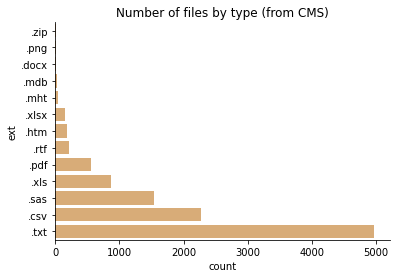

In [25]:
# visualize filetypes
sns.barplot(x='count',
            y='ext',
            data=ft_counts.sort_values('count'),
            color='#E8AE68')
sns.despine()
plt.title('Number of files by type (from CMS)')

## zip files
There were some zip files extracted from other zip files.  Why?

In [26]:
zips = glob(os.path.join(EXTRACTED_ZIP_FILES_PATH, '**/*.zip'), recursive=True)
zips

['zip_extract/CAP-Detail-File-2012-12/CAP-Detail-File-2012-12.zip',
 'zip_extract/CAP_Readme_File/CAP_Readme_File.zip',
 'zip_extract/Contract-Summary-August-2007/Contract-Summary-August-2007.zip',
 'zip_extract/Contract-Summary-August-2007/monthly-enrollment-cpsc-june-2020.zip',
 'zip_extract/SCC-Enrollment-MA-2018-10/SCC_Enrollment_MA_Alt_2018_10.zip',
 'zip_extract/SCC-Enrollment-MA-Alt-2015-09/New PKZIP File - Copy (13).zip',
 'zip_extract/Summary-Report-August-2006/monthly-enrollment-cpsc-june-2020.zip',
 'zip_extract/Summary-Report-August-2006/Summary-Report-August-2006.zip']

In [27]:
for z in zips:
    path, filename = os.path.split(z)
    print(os.listdir(path))

['CAP-Detail-File-2012-12.zip', 'CAP_Detail_File_2012_12.csv']
['CAP_readme_06082010.txt', 'CAP_Readme_File.zip']
['Contract-Summary-August-2007.zip', 'monthly summary report_Aug 2007_07302007.xls', 'monthly-enrollment-cpsc-june-2020.zip']
['Contract-Summary-August-2007.zip', 'monthly summary report_Aug 2007_07302007.xls', 'monthly-enrollment-cpsc-june-2020.zip']
['Read_Me_SCC_Enrollment_MA_2018.txt', 'SCC_Enrollment_MA_2018_10.csv', 'SCC_Enrollment_MA_Alt_2018_10.zip']
['New PKZIP File - Copy (13).zip', 'Read_Me_SCC_Enrollment_MA_2015_Alternative_File.txt', 'SCC_Enrollment_MA_Alt_2015_09.csv']
['monthly summary report_Aug 2006_08142006.xls', 'monthly-enrollment-cpsc-june-2020.zip', 'Summary-Report-August-2006.zip']
['monthly summary report_Aug 2006_08142006.xls', 'monthly-enrollment-cpsc-june-2020.zip', 'Summary-Report-August-2006.zip']


In [28]:
import filecmp

def compare_zips(zip_):
    print('Files in dir:')
    path, filename = os.path.split(zip_)
    print(os.listdir(path))

    print("Zip contents:")
    with zipfile.ZipFile(zip_, 'r') as z:
        
        # Get list of files names in zip
        inzip = z.namelist() 
        print(inzip)
        
        # extract zip to tmp folder
        os.makedirs('tmp')
        
        z.extractall('tmp')
        
        print('Is the first file in the zip identical to a file in the dir?')
        print(filecmp.cmp(os.path.join('tmp',inzip[0]), os.path.join(path, inzip[0])))
        
        # clean up
        shutil.rmtree('tmp') 


In [29]:
compare_zips(zips[0])

Files in dir:
['CAP-Detail-File-2012-12.zip', 'CAP_Detail_File_2012_12.csv']
Zip contents:
['CAP_Detail_File_2012_12.csv']
Is the first file in the zip identical to a file in the dir?
True


In [30]:
compare_zips(zips[1])

Files in dir:
['CAP_readme_06082010.txt', 'CAP_Readme_File.zip']
Zip contents:
['CAP_readme_06082010.txt']
Is the first file in the zip identical to a file in the dir?
True


In [31]:
compare_zips(zips[2])

Files in dir:
['Contract-Summary-August-2007.zip', 'monthly summary report_Aug 2007_07302007.xls', 'monthly-enrollment-cpsc-june-2020.zip']
Zip contents:
['monthly summary report_Aug 2007_07302007.xls']
Is the first file in the zip identical to a file in the dir?
True


These zip files were zipped into other zip files, but appear to contain the same content as the folders in the directory.  It would be good to check if this is true for all of them, but it looks like they can be safely discarded.

## Alternate versions
Some files seem to have alternative versions with alt in the filename.  Some exploration is required to find out how the alternative files differ.

See how many `alt` files there are.

In [32]:
alts = glob(os.path.join(EXTRACTED_ZIP_FILES_PATH, '**Alt**/*.*'), recursive=True)
alts[:5]

['zip_extract/MA-Enrollment-by-SCC-Alt-April-2008/readme_scc_enrollment_ma_2008_Alternative_File.txt',
 'zip_extract/MA-Enrollment-by-SCC-Alt-April-2008/SCC_Enrollment_MA_2008_04_Alt.csv',
 'zip_extract/MA-Enrollment-by-SCC-Alt-April-2009/Read_Me_SCC_Enrollment_MA_2009_Alternative_File.txt',
 'zip_extract/MA-Enrollment-by-SCC-Alt-April-2009/SCC_Enrollment_MA_2009_04_Alt.csv',
 'zip_extract/MA-Enrollment-by-SCC-Alt-April-2010/Read_Me_SCC_Enrollment_MA_2010_Alternative_File.txt']

In [33]:
# number of alternative files
len(alts)

561

These need to be explored to see how they differ from the original versions.

## txt files
Are the text files delimited tables or text content?

In [34]:
txts = glob(os.path.join(EXTRACTED_ZIP_FILES_PATH, '**/*.txt'), recursive=True)

In [35]:
txt = np.random.choice(txts)
print(txt)
pd.read_csv(np.random.choice(txts), delimiter='\t')

zip_extract/PDP-Enrollment-by-SCC-Full-January-2010/Read_Me_SCC_Enrollment_PDP_2010.txt


,pbp_a_hnumber,pbp_a_plan_identifier,segment_id,pbp_a_ben_cov,pbp_a_plan_type,orgtype,bid_id,version,pbp_b16a_bendesc_yn,pbp_b16a_bendesc_ehc,...,pbp_b16a_copay_amt_oemax,pbp_b16a_copay_amt_pcmin,pbp_b16a_copay_amt_pcmax,pbp_b16a_copay_amt_ftmin,pbp_b16a_copay_amt_ftmax,pbp_b16a_copay_amt_dxmin,pbp_b16a_copay_amt_dxmax,pbp_b16a_auth_yn,pbp_b16a_refer_yn,pbp_d_opt_identifier
0,H0028,4,0,1.0,1,1,H0028_004_0,5,1,1111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1
1,H0028,4,0,1.0,1,1,H0028_004_0,5,1,1111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2
2,H0028,11,0,1.0,1,1,H0028_011_0,5,1,1111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1
3,H0028,16,0,1.0,1,1,H0028_016_0,4,1,1111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1
4,H0028,16,0,1.0,1,1,H0028_016_0,4,1,1111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,R7220,1,0,1.0,31,11,R7220_001_0,5,1,1111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2
1256,R7220,2,0,1.0,31,11,R7220_002_0,5,1,1110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,3
1257,R7444,1,0,1.0,31,11,R7444_001_0,5,1,1111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2
1258,R7444,8,0,1.0,31,11,R7444_008_0,3,1,1111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1


In [36]:
# Most txt files seem to be content descriptions
pd.read_csv('zip_extract/Monthly-Enrollment-by-Contract-April-2008/readme_monthly_report_by_Contract.txt', delimiter='\t')

,Monthly Report by Contract Package
0,monthly report by contract_Oct2007_10022007.zip
1,The Monthly Report by Contract_MMMYYYY_mmddyyy...
2,consisting of the following files:
3,readme_monthly_report_by_Contract.txt - this file
4,monthly report by contract_MMMYYYY_mmddyyyy.xl...
5,monthly report by contract_MMMYYYY_mmddyyyy.cs...
6,Please note that anywhere you see MMMYYYY it d...
7,year the data covers and mmddyyyy = the 2 digi...
8,was created
9,The two data files contain the same base rows ...


In [37]:
# some txt files contain data
pd.read_csv('zip_extract/PBP-Benefits-2016/pbp_Section_D_opts.txt', delimiter='\t')

,pbp_a_hnumber,pbp_a_plan_identifier,segment_id,pbp_a_ben_cov,pbp_a_plan_type,orgtype,bid_id,version,pbp_d_opt_identifier,pbp_d_opt_description,pbp_d_amt_opt_premium,pbp_d_opt_maxplan_ben_cov_yn,pbp_d_opt_maxplan_ben_cov_amt,pbp_d_opt_maxplan_per,pbp_d_opt_deduct_yn,pbp_d_opt_deduct_amt,pbp_d_opt_secb_cats,pbp_d_opt_other_benefits
0,H0028,4,0,1,1,1,H0028_004_0,3,2,MyOption Vision,15.3,2,NaN,NaN,2,NaN,NaN,17a;17a;17b;17b;
1,H0028,4,0,1,1,1,H0028_004_0,3,1,MyOption Dental - High PPO,32.6,1,1500.0,3.0,1,50.0,16a;16a;16b;16b;,NaN
2,H0104,12,0,1,4,1,H0104_012_0,3,1,Vision and Hearing,11.0,2,NaN,NaN,2,NaN,17b;18a;18b;,NaN
3,H0104,13,0,1,4,1,H0104_013_0,3,1,Vision and Hearing,11.0,2,NaN,NaN,2,NaN,17b;18a;18b;,NaN
4,H0104,14,0,1,4,1,H0104_014_0,3,1,Vision and Hearing,11.0,2,NaN,NaN,2,NaN,17b;18a;18b;,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,R5941,15,0,1,31,11,R5941_015_0,8,1,Preventive Dental Package,17.0,2,NaN,NaN,2,NaN,NaN,16a;
1366,R5941,15,0,1,31,11,R5941_015_0,8,3,Enhanced Dental and Vision Package,38.0,2,NaN,NaN,2,NaN,NaN,16a;16b;17b;
1367,R5941,15,0,1,31,11,R5941_015_0,8,2,Dental and Vision Package,25.0,2,NaN,NaN,2,NaN,NaN,16a;16b;17b;
1368,R7444,1,0,1,31,11,R7444_001_0,2,1,Fitness Rider,19.0,2,NaN,NaN,2,NaN,14c;,NaN


In [38]:
os.listdir('zip_extract/PBP-Benefits-2016')

['pbp_b10.sas',
 'pbp_b10_amb_trans.txt',
 'pbp_b11.sas',
 'pbp_b11_dme_prosth_orth_sup.txt',
 'pbp_b12.sas',
 'pbp_b12_renal_dialysis.txt',
 'pbp_b13.sas',
 'pbp_b13_other_services.txt',
 'pbp_b13h_1.sas',
 'pbp_b13h_2.sas',
 'pbp_b13h_other_services_1.txt',
 'pbp_b13h_other_services_2.txt',
 'pbp_b14.sas',
 'pbp_b14_preventive.txt',
 'pbp_b15.sas',
 'pbp_b15_partb_rx_drugs.txt',
 'pbp_b16.sas',
 'pbp_b16_dental.txt',
 'pbp_b17.sas',
 'pbp_b17_eye_exams_wear.txt',
 'pbp_b18.sas',
 'pbp_b18_hearing_exams_aids.txt',
 'pbp_b1a.sas',
 'pbp_b1a_2.sas',
 'pbp_b1a_inpat_hosp.txt',
 'pbp_b1a_inpat_hosp_2.txt',
 'pbp_b1b.sas',
 'pbp_b1b_2.sas',
 'pbp_b1b_inpat_hosp.txt',
 'pbp_b1b_inpat_hosp_2.txt',
 'pbp_b2.sas',
 'pbp_b20.sas',
 'pbp_b20.txt',
 'pbp_b2_snf.txt',
 'pbp_b3.sas',
 'pbp_b3_corf.txt',
 'pbp_b4.sas',
 'pbp_b4_emerg_urgent.txt',
 'pbp_b5.sas',
 'pbp_b5_partial_hosp.txt',
 'pbp_b6.sas',
 'pbp_b6_home_health.txt',
 'pbp_b7.sas',
 'pbp_b7_health_prof.txt',
 'pbp_b8.sas',
 'pbp_b8_clin

The text files continue both tabular data and readme text. Further exploration is needed to determine how to separate them and if the tabular data is also available in other files.

## sas files
My initial assumption is that these were sas dataset files, but they don't seem to be.  Further exploration is needed.

In [39]:
# maybe the sas files are not sas files?
pd.read_sas('zip_extract/PBP-Benefits-2016/pbp_Section_D_opt.sas', format='sas7bdat' )

ValueError: magic number mismatch (not a SAS file?)

In [40]:
pd.read_sas('zip_extract/PBP-Benefits-2016/pbp_Section_D_opt.sas', format='xport' )

ValueError: Header record is not an XPORT file.

In [41]:
with open('zip_extract/PBP-Benefits-2016/pbp_Section_D_opt.sas', 'r') as f:
    print(f.read())

*pbp_Section_D_opt.sas;

libname out '.\sas_data_sets\PBP';
options pageno=1 linesize = 200 nocenter;

data pbp_Section_D_opt;

length
	pbp_a_hnumber                    $5
	pbp_a_plan_identifier            $3
	pbp_a_ben_cov                    $1
	pbp_a_plan_type                  $2
	orgtype                          $2
	bid_id                           $13
	pbp_d_opt_identifier             $3
	pbp_d_opt_description            $50
	pbp_d_opt_maxplan_ben_cov_yn     $1
	pbp_d_opt_maxplan_per            $1
	pbp_d_opt_deduct_yn              $1
	pbp_d_opt_secb_cats              $255
	pbp_d_opt_other_benefits         $255
;

infile '.\pbp\pbp_Section_D_opts.txt' delimiter = '09'x
dsd lrecl = 30000 firstobs=2 missover;


input
	pbp_a_hnumber
	pbp_a_plan_identifier
	segment_id
	pbp_a_ben_cov
	pbp_a_plan_type
	orgtype
	bid_id
	version
	pbp_d_opt_identifier
	pbp_d_opt_description
	pbp_d_amt_opt_premium
	pbp_d_opt_maxplan_ben_cov_yn
	pbp_d_opt_maxplan_ben_cov_amt
	pbp_d_opt_maxplan_per
	pbp_d_opt_d

The tested sas files are not dataset files but SAS program files.  The inspected file does not seem to contain data so they may not be necessary.  Further investigation is necessary to see if all the sas files are program files and if they can be safely ignored.